In [413]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [414]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

D:\Anoconda3\envs\tf\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [415]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\原数据\K_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[8].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers[:0]:
        layer.trainable = False
    Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        #layers.Dropout(0.5),
        Dense,
        layers.Dropout(0.5),
        global_average_layer,
        prediction_layer
    ])
    base_learning_rate = 0.001
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
    model1.summary()
    return model1

In [416]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [417]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [418]:
batch_size=256

In [419]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\不自然数据\1正2345负')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [420]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [421]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [422]:
prediction_result_cv = []
prediction_result_ind = []

In [423]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze')

In [424]:
out = os.getcwd() + '\\'

In [425]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model_150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0 

8/8 - 0s - loss: 0.6014 - accuracy: 0.6757 - val_loss: 0.6361 - val_accuracy: 0.6667

Epoch 00025: val_loss did not improve from 0.62942
Epoch 26/300
8/8 - 0s - loss: 0.5972 - accuracy: 0.6891 - val_loss: 0.6335 - val_accuracy: 0.6222

Epoch 00026: val_loss did not improve from 0.62942
Epoch 27/300
8/8 - 0s - loss: 0.5920 - accuracy: 0.6817 - val_loss: 0.6384 - val_accuracy: 0.6489

Epoch 00027: val_loss did not improve from 0.62942
Epoch 28/300
8/8 - 0s - loss: 0.5857 - accuracy: 0.6985 - val_loss: 0.6298 - val_accuracy: 0.6400

Epoch 00028: val_loss did not improve from 0.62942
Epoch 29/300
8/8 - 0s - loss: 0.5747 - accuracy: 0.6980 - val_loss: 0.6290 - val_accuracy: 0.6356

Epoch 00029: val_loss improved from 0.62942 to 0.62903, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_0.h5
Epoch 30/300
8/8 - 0s - loss: 0.5874 - accuracy: 0.6846 - val_loss: 0.6400 - val_accuracy: 0.6178

Epoch 00030: val_loss did 

8/8 - 0s - loss: 0.4154 - accuracy: 0.8092 - val_loss: 0.6667 - val_accuracy: 0.6533

Epoch 00078: val_loss did not improve from 0.62780
Epoch 79/300
8/8 - 0s - loss: 0.4711 - accuracy: 0.7716 - val_loss: 0.6491 - val_accuracy: 0.6444

Epoch 00079: val_loss did not improve from 0.62780
Epoch 80/300
8/8 - 0s - loss: 0.4147 - accuracy: 0.8107 - val_loss: 0.6638 - val_accuracy: 0.6178

Epoch 00080: val_loss did not improve from 0.62780
Epoch 81/300
8/8 - 0s - loss: 0.3802 - accuracy: 0.8295 - val_loss: 0.7127 - val_accuracy: 0.6267

Epoch 00081: val_loss did not improve from 0.62780
Epoch 82/300
8/8 - 0s - loss: 0.4649 - accuracy: 0.7701 - val_loss: 0.6561 - val_accuracy: 0.6222

Epoch 00082: val_loss did not improve from 0.62780
Epoch 83/300
8/8 - 0s - loss: 0.3778 - accuracy: 0.8339 - val_loss: 0.6712 - val_accuracy: 0.6133

Epoch 00083: val_loss did not improve from 0.62780
Epoch 84/300
8/8 - 0s - loss: 0.4330 - accuracy: 0.7944 - val_loss: 0.6641 - val_accuracy: 0.6178

Epoch 00084: v


Epoch 00014: val_loss did not improve from 0.65222
Epoch 15/300
8/8 - 0s - loss: 0.6206 - accuracy: 0.6471 - val_loss: 0.6510 - val_accuracy: 0.6178

Epoch 00015: val_loss improved from 0.65222 to 0.65098, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_1.h5
Epoch 16/300
8/8 - 0s - loss: 0.6110 - accuracy: 0.6594 - val_loss: 0.6480 - val_accuracy: 0.6267

Epoch 00016: val_loss improved from 0.65098 to 0.64803, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_1.h5
Epoch 17/300
8/8 - 0s - loss: 0.6149 - accuracy: 0.6609 - val_loss: 0.6460 - val_accuracy: 0.6356

Epoch 00017: val_loss improved from 0.64803 to 0.64604, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_1.h5
Epoch 18/300
8/8 - 0s - loss: 0.6218 - accuracy: 0.6589 - val_loss: 0.6520 - val_acc

8/8 - 0s - loss: 0.4647 - accuracy: 0.7731 - val_loss: 0.6778 - val_accuracy: 0.5733

Epoch 00065: val_loss did not improve from 0.64397
Epoch 66/300
8/8 - 0s - loss: 0.4417 - accuracy: 0.7939 - val_loss: 0.6560 - val_accuracy: 0.6356

Epoch 00066: val_loss did not improve from 0.64397
Epoch 67/300
8/8 - 0s - loss: 0.4547 - accuracy: 0.7929 - val_loss: 0.6518 - val_accuracy: 0.6089

Epoch 00067: val_loss did not improve from 0.64397
Epoch 68/300
8/8 - 0s - loss: 0.4164 - accuracy: 0.8191 - val_loss: 0.6759 - val_accuracy: 0.6489

Epoch 00068: val_loss did not improve from 0.64397
Epoch 69/300
8/8 - 0s - loss: 0.4591 - accuracy: 0.7790 - val_loss: 0.6618 - val_accuracy: 0.5867

Epoch 00069: val_loss did not improve from 0.64397
Epoch 70/300
8/8 - 0s - loss: 0.4525 - accuracy: 0.7800 - val_loss: 0.6679 - val_accuracy: 0.5556

Epoch 00070: val_loss did not improve from 0.64397
Epoch 71/300
8/8 - 0s - loss: 0.4125 - accuracy: 0.8117 - val_loss: 0.6582 - val_accuracy: 0.6044

Epoch 00071: v


Epoch 00006: val_loss improved from 0.64777 to 0.64118, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_2.h5
Epoch 7/300
8/8 - 0s - loss: 0.6483 - accuracy: 0.6258 - val_loss: 0.6353 - val_accuracy: 0.6667

Epoch 00007: val_loss improved from 0.64118 to 0.63528, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_2.h5
Epoch 8/300
8/8 - 0s - loss: 0.6398 - accuracy: 0.6431 - val_loss: 0.6341 - val_accuracy: 0.7067

Epoch 00008: val_loss improved from 0.63528 to 0.63410, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_2.h5
Epoch 9/300
8/8 - 0s - loss: 0.6327 - accuracy: 0.6431 - val_loss: 0.6374 - val_accuracy: 0.6089

Epoch 00009: val_loss did not improve from 0.63410
Epoch 10/300
8/8 - 0s - loss: 0.6260 - accuracy: 0.6649 - val_loss: 0.6242 - val_accura


Epoch 00051: val_loss did not improve from 0.60152
Epoch 52/300
8/8 - 0s - loss: 0.5183 - accuracy: 0.7449 - val_loss: 0.6330 - val_accuracy: 0.6178

Epoch 00052: val_loss did not improve from 0.60152
Epoch 53/300
8/8 - 0s - loss: 0.5077 - accuracy: 0.7647 - val_loss: 0.6124 - val_accuracy: 0.6578

Epoch 00053: val_loss did not improve from 0.60152
Epoch 54/300
8/8 - 0s - loss: 0.4889 - accuracy: 0.7701 - val_loss: 0.5992 - val_accuracy: 0.6889

Epoch 00054: val_loss improved from 0.60152 to 0.59921, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_2.h5
Epoch 55/300
8/8 - 0s - loss: 0.5070 - accuracy: 0.7558 - val_loss: 0.6028 - val_accuracy: 0.6933

Epoch 00055: val_loss did not improve from 0.59921
Epoch 56/300
8/8 - 0s - loss: 0.4925 - accuracy: 0.7721 - val_loss: 0.6383 - val_accuracy: 0.6178

Epoch 00056: val_loss did not improve from 0.59921
Epoch 57/300
8/8 - 0s - loss: 0.5052 - accuracy: 0.7533 - va


Epoch 00104: val_loss did not improve from 0.59688
Epoch 105/300
8/8 - 0s - loss: 0.3744 - accuracy: 0.8280 - val_loss: 0.6144 - val_accuracy: 0.6711

Epoch 00105: val_loss did not improve from 0.59688
Epoch 106/300
8/8 - 0s - loss: 0.3284 - accuracy: 0.8596 - val_loss: 0.6118 - val_accuracy: 0.6667

Epoch 00106: val_loss did not improve from 0.59688
Epoch 107/300
8/8 - 0s - loss: 0.3084 - accuracy: 0.8754 - val_loss: 0.6397 - val_accuracy: 0.6533

Epoch 00107: val_loss did not improve from 0.59688
Epoch 108/300
8/8 - 0s - loss: 0.3219 - accuracy: 0.8670 - val_loss: 0.6538 - val_accuracy: 0.6756

Epoch 00108: val_loss did not improve from 0.59688
Epoch 109/300
8/8 - 0s - loss: 0.2965 - accuracy: 0.8730 - val_loss: 0.6114 - val_accuracy: 0.6711

Epoch 00109: val_loss did not improve from 0.59688
Epoch 110/300
8/8 - 0s - loss: 0.3591 - accuracy: 0.8344 - val_loss: 0.6162 - val_accuracy: 0.6667

Epoch 00110: val_loss did not improve from 0.59688
Epoch 111/300
8/8 - 0s - loss: 0.3199 - ac

8/8 - 0s - loss: 0.6347 - accuracy: 0.6461 - val_loss: 0.6380 - val_accuracy: 0.6578

Epoch 00011: val_loss improved from 0.63896 to 0.63802, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_3.h5
Epoch 12/300
8/8 - 0s - loss: 0.6337 - accuracy: 0.6406 - val_loss: 0.6370 - val_accuracy: 0.6667

Epoch 00012: val_loss improved from 0.63802 to 0.63698, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_3.h5
Epoch 13/300
8/8 - 0s - loss: 0.6259 - accuracy: 0.6525 - val_loss: 0.6364 - val_accuracy: 0.6756

Epoch 00013: val_loss improved from 0.63698 to 0.63638, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_3.h5
Epoch 14/300
8/8 - 0s - loss: 0.6257 - accuracy: 0.6515 - val_loss: 0.6335 - val_accuracy: 0.6356

Epoch 00014: val_loss improved from 0.63638 to 0.6

8/8 - 0s - loss: 0.5008 - accuracy: 0.7608 - val_loss: 0.6238 - val_accuracy: 0.6489

Epoch 00052: val_loss did not improve from 0.60010
Epoch 53/300
8/8 - 0s - loss: 0.5283 - accuracy: 0.7271 - val_loss: 0.6063 - val_accuracy: 0.6800

Epoch 00053: val_loss did not improve from 0.60010
Epoch 54/300
8/8 - 0s - loss: 0.4971 - accuracy: 0.7627 - val_loss: 0.6093 - val_accuracy: 0.6711

Epoch 00054: val_loss did not improve from 0.60010
Epoch 55/300
8/8 - 0s - loss: 0.4969 - accuracy: 0.7484 - val_loss: 0.6398 - val_accuracy: 0.6533

Epoch 00055: val_loss did not improve from 0.60010
Epoch 56/300
8/8 - 0s - loss: 0.5143 - accuracy: 0.7395 - val_loss: 0.6003 - val_accuracy: 0.6933

Epoch 00056: val_loss did not improve from 0.60010
Epoch 57/300
8/8 - 0s - loss: 0.5074 - accuracy: 0.7499 - val_loss: 0.6090 - val_accuracy: 0.6711

Epoch 00057: val_loss did not improve from 0.60010
Epoch 58/300
8/8 - 0s - loss: 0.4910 - accuracy: 0.7578 - val_loss: 0.6012 - val_accuracy: 0.6756

Epoch 00058: v

8/8 - 0s - loss: 0.3092 - accuracy: 0.8665 - val_loss: 0.6352 - val_accuracy: 0.6667

Epoch 00106: val_loss did not improve from 0.59933
Epoch 107/300
8/8 - 0s - loss: 0.3613 - accuracy: 0.8379 - val_loss: 0.6016 - val_accuracy: 0.7022

Epoch 00107: val_loss did not improve from 0.59933
Epoch 108/300
8/8 - 0s - loss: 0.3259 - accuracy: 0.8537 - val_loss: 0.6697 - val_accuracy: 0.6356

Epoch 00108: val_loss did not improve from 0.59933
Epoch 109/300
8/8 - 0s - loss: 0.3580 - accuracy: 0.8359 - val_loss: 0.6146 - val_accuracy: 0.6844

Epoch 00109: val_loss did not improve from 0.59933
Epoch 110/300
8/8 - 0s - loss: 0.3125 - accuracy: 0.8675 - val_loss: 0.6194 - val_accuracy: 0.6800

Epoch 00110: val_loss did not improve from 0.59933
Epoch 111/300
8/8 - 0s - loss: 0.3612 - accuracy: 0.8389 - val_loss: 0.6458 - val_accuracy: 0.6444

Epoch 00111: val_loss did not improve from 0.59933
Epoch 112/300
8/8 - 0s - loss: 0.2953 - accuracy: 0.8749 - val_loss: 0.6347 - val_accuracy: 0.6844

Epoch 00


Epoch 00010: val_loss improved from 0.63780 to 0.63535, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_4.h5
Epoch 11/300
8/8 - 0s - loss: 0.6345 - accuracy: 0.6401 - val_loss: 0.6321 - val_accuracy: 0.6311

Epoch 00011: val_loss improved from 0.63535 to 0.63213, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_4.h5
Epoch 12/300
8/8 - 0s - loss: 0.6340 - accuracy: 0.6461 - val_loss: 0.6354 - val_accuracy: 0.6400

Epoch 00012: val_loss did not improve from 0.63213
Epoch 13/300
8/8 - 0s - loss: 0.6308 - accuracy: 0.6471 - val_loss: 0.6379 - val_accuracy: 0.6489

Epoch 00013: val_loss did not improve from 0.63213
Epoch 14/300
8/8 - 0s - loss: 0.6261 - accuracy: 0.6574 - val_loss: 0.6312 - val_accuracy: 0.6711

Epoch 00014: val_loss improved from 0.63213 to 0.63115, saving model to D:\PycharmProjects\pythonProject\Papernew_datachang


Epoch 00052: val_loss did not improve from 0.59763
Epoch 53/300
8/8 - 0s - loss: 0.4954 - accuracy: 0.7647 - val_loss: 0.6410 - val_accuracy: 0.6533

Epoch 00053: val_loss did not improve from 0.59763
Epoch 54/300
8/8 - 0s - loss: 0.5238 - accuracy: 0.7425 - val_loss: 0.6065 - val_accuracy: 0.6844

Epoch 00054: val_loss did not improve from 0.59763
Epoch 55/300
8/8 - 0s - loss: 0.5030 - accuracy: 0.7568 - val_loss: 0.6110 - val_accuracy: 0.6711

Epoch 00055: val_loss did not improve from 0.59763
Epoch 56/300
8/8 - 0s - loss: 0.5027 - accuracy: 0.7593 - val_loss: 0.6239 - val_accuracy: 0.6756

Epoch 00056: val_loss did not improve from 0.59763
Epoch 57/300
8/8 - 0s - loss: 0.4832 - accuracy: 0.7692 - val_loss: 0.6055 - val_accuracy: 0.6800

Epoch 00057: val_loss did not improve from 0.59763
Epoch 58/300
8/8 - 0s - loss: 0.4977 - accuracy: 0.7603 - val_loss: 0.6131 - val_accuracy: 0.6578

Epoch 00058: val_loss did not improve from 0.59763
Epoch 59/300
8/8 - 0s - loss: 0.4624 - accuracy:

Model: "sequential_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_155 (Functional)       (None, 5, 128)            199680    
_________________________________________________________________
dense_310 (Dense)            (None, 5, 64)             8256      
_________________________________________________________________
dropout_155 (Dropout)        (None, 5, 64)             0         
_________________________________________________________________
global_average_pooling1d_155 (None, 64)                0         
_________________________________________________________________
dense_311 (Dense)            (None, 1)                 65        
Total params: 208,001
Trainable params: 208,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.6913 - accuracy: 0.5348 - val_loss: 0.6881 - val_accuracy: 0.5733

Epoch 00001: v


Epoch 00034: val_loss did not improve from 0.64182
Epoch 35/300
8/8 - 0s - loss: 0.5725 - accuracy: 0.6965 - val_loss: 0.6475 - val_accuracy: 0.6044

Epoch 00035: val_loss did not improve from 0.64182
Epoch 36/300
8/8 - 0s - loss: 0.5533 - accuracy: 0.7098 - val_loss: 0.6506 - val_accuracy: 0.6267

Epoch 00036: val_loss did not improve from 0.64182
Epoch 37/300
8/8 - 0s - loss: 0.5496 - accuracy: 0.7118 - val_loss: 0.6546 - val_accuracy: 0.6133

Epoch 00037: val_loss did not improve from 0.64182
Epoch 38/300
8/8 - 0s - loss: 0.5727 - accuracy: 0.7019 - val_loss: 0.6546 - val_accuracy: 0.5911

Epoch 00038: val_loss did not improve from 0.64182
Epoch 39/300
8/8 - 0s - loss: 0.5568 - accuracy: 0.7049 - val_loss: 0.6554 - val_accuracy: 0.6222

Epoch 00039: val_loss did not improve from 0.64182
Epoch 40/300
8/8 - 0s - loss: 0.5361 - accuracy: 0.7291 - val_loss: 0.6387 - val_accuracy: 0.5956

Epoch 00040: val_loss improved from 0.64182 to 0.63874, saving model to D:\PycharmProjects\pythonPr


Epoch 00086: val_loss did not improve from 0.63623
Epoch 87/300
8/8 - 0s - loss: 0.4311 - accuracy: 0.7954 - val_loss: 0.6622 - val_accuracy: 0.6311

Epoch 00087: val_loss did not improve from 0.63623
Epoch 88/300
8/8 - 0s - loss: 0.3959 - accuracy: 0.8255 - val_loss: 0.6881 - val_accuracy: 0.5822

Epoch 00088: val_loss did not improve from 0.63623
Epoch 89/300
8/8 - 0s - loss: 0.3901 - accuracy: 0.8181 - val_loss: 0.6893 - val_accuracy: 0.5911

Epoch 00089: val_loss did not improve from 0.63623
Epoch 90/300
8/8 - 0s - loss: 0.3861 - accuracy: 0.8230 - val_loss: 0.6753 - val_accuracy: 0.6000

Epoch 00090: val_loss did not improve from 0.63623
Epoch 91/300
8/8 - 0s - loss: 0.3607 - accuracy: 0.8448 - val_loss: 0.6791 - val_accuracy: 0.6311

Epoch 00091: val_loss did not improve from 0.63623
Epoch 92/300
8/8 - 0s - loss: 0.3406 - accuracy: 0.8562 - val_loss: 0.6890 - val_accuracy: 0.6178

Epoch 00092: val_loss did not improve from 0.63623
Epoch 93/300
8/8 - 0s - loss: 0.3997 - accuracy:

8/8 - 0s - loss: 0.6142 - accuracy: 0.6589 - val_loss: 0.6463 - val_accuracy: 0.6489

Epoch 00013: val_loss improved from 0.64839 to 0.64629, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_6.h5
Epoch 14/300
8/8 - 0s - loss: 0.6204 - accuracy: 0.6569 - val_loss: 0.6577 - val_accuracy: 0.6000

Epoch 00014: val_loss did not improve from 0.64629
Epoch 15/300
8/8 - 0s - loss: 0.6077 - accuracy: 0.6658 - val_loss: 0.6460 - val_accuracy: 0.6711

Epoch 00015: val_loss improved from 0.64629 to 0.64602, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_6.h5
Epoch 16/300
8/8 - 0s - loss: 0.6270 - accuracy: 0.6550 - val_loss: 0.6487 - val_accuracy: 0.6622

Epoch 00016: val_loss did not improve from 0.64602
Epoch 17/300
8/8 - 0s - loss: 0.6027 - accuracy: 0.6762 - val_loss: 0.6451 - val_accuracy: 0.6622

Epoch 00017: val_loss improved from 0.


Epoch 00061: val_loss did not improve from 0.63978
Epoch 62/300
8/8 - 0s - loss: 0.4826 - accuracy: 0.7612 - val_loss: 0.6673 - val_accuracy: 0.6400

Epoch 00062: val_loss did not improve from 0.63978
Epoch 63/300
8/8 - 0s - loss: 0.4558 - accuracy: 0.7944 - val_loss: 0.6668 - val_accuracy: 0.6356

Epoch 00063: val_loss did not improve from 0.63978
Epoch 64/300
8/8 - 0s - loss: 0.4349 - accuracy: 0.7993 - val_loss: 0.6996 - val_accuracy: 0.6133

Epoch 00064: val_loss did not improve from 0.63978
Epoch 65/300
8/8 - 0s - loss: 0.4880 - accuracy: 0.7716 - val_loss: 0.6772 - val_accuracy: 0.6000

Epoch 00065: val_loss did not improve from 0.63978
Epoch 66/300
8/8 - 0s - loss: 0.4705 - accuracy: 0.7771 - val_loss: 0.6702 - val_accuracy: 0.6222

Epoch 00066: val_loss did not improve from 0.63978
Epoch 67/300
8/8 - 0s - loss: 0.4492 - accuracy: 0.7978 - val_loss: 0.6771 - val_accuracy: 0.6133

Epoch 00067: val_loss did not improve from 0.63978
Epoch 68/300
8/8 - 0s - loss: 0.4570 - accuracy:

8/8 - 0s - loss: 0.6685 - accuracy: 0.5961 - val_loss: 0.6712 - val_accuracy: 0.5733

Epoch 00003: val_loss improved from 0.67427 to 0.67123, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_7.h5
Epoch 4/300
8/8 - 0s - loss: 0.6651 - accuracy: 0.6110 - val_loss: 0.6621 - val_accuracy: 0.6178

Epoch 00004: val_loss improved from 0.67123 to 0.66212, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_7.h5
Epoch 5/300
8/8 - 0s - loss: 0.6556 - accuracy: 0.6080 - val_loss: 0.6558 - val_accuracy: 0.6133

Epoch 00005: val_loss improved from 0.66212 to 0.65583, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_7.h5
Epoch 6/300
8/8 - 0s - loss: 0.6483 - accuracy: 0.6283 - val_loss: 0.6520 - val_accuracy: 0.6489

Epoch 00006: val_loss improved from 0.65583 to 0.6519


Epoch 00048: val_loss did not improve from 0.62574
Epoch 49/300
8/8 - 0s - loss: 0.5220 - accuracy: 0.7430 - val_loss: 0.6464 - val_accuracy: 0.6444

Epoch 00049: val_loss did not improve from 0.62574
Epoch 50/300
8/8 - 0s - loss: 0.5048 - accuracy: 0.7578 - val_loss: 0.6482 - val_accuracy: 0.6267

Epoch 00050: val_loss did not improve from 0.62574
Epoch 51/300
8/8 - 0s - loss: 0.4927 - accuracy: 0.7692 - val_loss: 0.6505 - val_accuracy: 0.6311

Epoch 00051: val_loss did not improve from 0.62574
Epoch 52/300
8/8 - 0s - loss: 0.5200 - accuracy: 0.7444 - val_loss: 0.6398 - val_accuracy: 0.6133

Epoch 00052: val_loss did not improve from 0.62574
Epoch 53/300
8/8 - 0s - loss: 0.4947 - accuracy: 0.7543 - val_loss: 0.6480 - val_accuracy: 0.6400

Epoch 00053: val_loss did not improve from 0.62574
Epoch 54/300
8/8 - 0s - loss: 0.5003 - accuracy: 0.7583 - val_loss: 0.6303 - val_accuracy: 0.6533

Epoch 00054: val_loss did not improve from 0.62574
Epoch 55/300
8/8 - 0s - loss: 0.5051 - accuracy:

8/8 - 1s - loss: 0.6874 - accuracy: 0.5593 - val_loss: 0.6826 - val_accuracy: 0.5357

Epoch 00001: val_loss improved from inf to 0.68258, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_8.h5
Epoch 2/300
8/8 - 0s - loss: 0.6739 - accuracy: 0.5687 - val_loss: 0.6730 - val_accuracy: 0.5714

Epoch 00002: val_loss improved from 0.68258 to 0.67302, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_8.h5
Epoch 3/300
8/8 - 0s - loss: 0.6622 - accuracy: 0.6107 - val_loss: 0.6657 - val_accuracy: 0.6295

Epoch 00003: val_loss improved from 0.67302 to 0.66574, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_8.h5
Epoch 4/300
8/8 - 0s - loss: 0.6589 - accuracy: 0.6092 - val_loss: 0.6654 - val_accuracy: 0.6205

Epoch 00004: val_loss improved from 0.66574 to 0.66544, s

8/8 - 0s - loss: 0.5465 - accuracy: 0.7297 - val_loss: 0.6286 - val_accuracy: 0.6696

Epoch 00042: val_loss did not improve from 0.62836
Epoch 43/300
8/8 - 0s - loss: 0.5258 - accuracy: 0.7391 - val_loss: 0.6598 - val_accuracy: 0.5982

Epoch 00043: val_loss did not improve from 0.62836
Epoch 44/300
8/8 - 0s - loss: 0.5360 - accuracy: 0.7243 - val_loss: 0.6374 - val_accuracy: 0.6295

Epoch 00044: val_loss did not improve from 0.62836
Epoch 45/300
8/8 - 0s - loss: 0.5384 - accuracy: 0.7233 - val_loss: 0.6494 - val_accuracy: 0.6741

Epoch 00045: val_loss did not improve from 0.62836
Epoch 46/300
8/8 - 0s - loss: 0.5431 - accuracy: 0.7268 - val_loss: 0.6360 - val_accuracy: 0.6295

Epoch 00046: val_loss did not improve from 0.62836
Epoch 47/300
8/8 - 0s - loss: 0.5285 - accuracy: 0.7431 - val_loss: 0.6340 - val_accuracy: 0.6652

Epoch 00047: val_loss did not improve from 0.62836
Epoch 48/300
8/8 - 0s - loss: 0.5198 - accuracy: 0.7446 - val_loss: 0.6461 - val_accuracy: 0.6473

Epoch 00048: v


Epoch 00092: val_loss did not improve from 0.61258
Epoch 93/300
8/8 - 0s - loss: 0.3877 - accuracy: 0.8202 - val_loss: 0.6205 - val_accuracy: 0.6518

Epoch 00093: val_loss did not improve from 0.61258
Epoch 94/300
8/8 - 0s - loss: 0.3752 - accuracy: 0.8409 - val_loss: 0.6979 - val_accuracy: 0.5938

Epoch 00094: val_loss did not improve from 0.61258
Epoch 95/300
8/8 - 0s - loss: 0.3799 - accuracy: 0.8360 - val_loss: 0.6548 - val_accuracy: 0.6295

Epoch 00095: val_loss did not improve from 0.61258
Epoch 96/300
8/8 - 0s - loss: 0.3719 - accuracy: 0.8394 - val_loss: 0.6608 - val_accuracy: 0.6652

Epoch 00096: val_loss did not improve from 0.61258
Epoch 97/300
8/8 - 0s - loss: 0.3686 - accuracy: 0.8429 - val_loss: 0.6411 - val_accuracy: 0.6652

Epoch 00097: val_loss did not improve from 0.61258
Epoch 98/300
8/8 - 0s - loss: 0.3589 - accuracy: 0.8394 - val_loss: 0.6367 - val_accuracy: 0.6518

Epoch 00098: val_loss did not improve from 0.61258
Epoch 99/300
8/8 - 0s - loss: 0.3891 - accuracy:

8/8 - 1s - loss: 0.6948 - accuracy: 0.5158 - val_loss: 0.6804 - val_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 0.68040, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_9.h5
Epoch 2/300
8/8 - 0s - loss: 0.6777 - accuracy: 0.5810 - val_loss: 0.6613 - val_accuracy: 0.6339

Epoch 00002: val_loss improved from 0.68040 to 0.66131, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_9.h5
Epoch 3/300
8/8 - 0s - loss: 0.6767 - accuracy: 0.5771 - val_loss: 0.6629 - val_accuracy: 0.6384

Epoch 00003: val_loss did not improve from 0.66131
Epoch 4/300
8/8 - 0s - loss: 0.6602 - accuracy: 0.5988 - val_loss: 0.6601 - val_accuracy: 0.6250

Epoch 00004: val_loss improved from 0.66131 to 0.66015, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\_9.h5
Epoch 

8/8 - 0s - loss: 0.5311 - accuracy: 0.7436 - val_loss: 0.6258 - val_accuracy: 0.6473

Epoch 00042: val_loss did not improve from 0.60876
Epoch 43/300
8/8 - 0s - loss: 0.5205 - accuracy: 0.7426 - val_loss: 0.6130 - val_accuracy: 0.6429

Epoch 00043: val_loss did not improve from 0.60876
Epoch 44/300
8/8 - 0s - loss: 0.5358 - accuracy: 0.7342 - val_loss: 0.6114 - val_accuracy: 0.6518

Epoch 00044: val_loss did not improve from 0.60876
Epoch 45/300
8/8 - 0s - loss: 0.5161 - accuracy: 0.7535 - val_loss: 0.6102 - val_accuracy: 0.6786

Epoch 00045: val_loss did not improve from 0.60876
Epoch 46/300
8/8 - 0s - loss: 0.5293 - accuracy: 0.7278 - val_loss: 0.6258 - val_accuracy: 0.6429

Epoch 00046: val_loss did not improve from 0.60876
Epoch 47/300
8/8 - 0s - loss: 0.5279 - accuracy: 0.7451 - val_loss: 0.6082 - val_accuracy: 0.6652

Epoch 00047: val_loss improved from 0.60876 to 0.60820, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD

8/8 - 0s - loss: 0.3864 - accuracy: 0.8261 - val_loss: 0.6566 - val_accuracy: 0.6295

Epoch 00093: val_loss did not improve from 0.60243
Epoch 94/300
8/8 - 0s - loss: 0.3861 - accuracy: 0.8310 - val_loss: 0.6438 - val_accuracy: 0.6473

Epoch 00094: val_loss did not improve from 0.60243
Epoch 95/300
8/8 - 0s - loss: 0.3720 - accuracy: 0.8409 - val_loss: 0.6670 - val_accuracy: 0.6250

Epoch 00095: val_loss did not improve from 0.60243
Epoch 96/300
8/8 - 0s - loss: 0.3464 - accuracy: 0.8582 - val_loss: 0.6346 - val_accuracy: 0.6518

Epoch 00096: val_loss did not improve from 0.60243
Epoch 97/300
8/8 - 0s - loss: 0.4019 - accuracy: 0.8207 - val_loss: 0.6399 - val_accuracy: 0.6607

Epoch 00097: val_loss did not improve from 0.60243
Epoch 98/300
8/8 - 0s - loss: 0.3607 - accuracy: 0.8384 - val_loss: 0.6501 - val_accuracy: 0.6429

Epoch 00098: val_loss did not improve from 0.60243
Epoch 99/300
8/8 - 0s - loss: 0.3395 - accuracy: 0.8552 - val_loss: 0.6599 - val_accuracy: 0.6339

Epoch 00099: v

In [426]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [427]:
roc_auc_list_val

[0.6754898862199746,
 0.6965880102040817,
 0.6703539823008849,
 0.7394121365360303,
 0.7384639696586599,
 0.7429677623261696,
 0.6664823008849556,
 0.6509165613147914,
 0.674067635903919,
 0.7222576530612245]

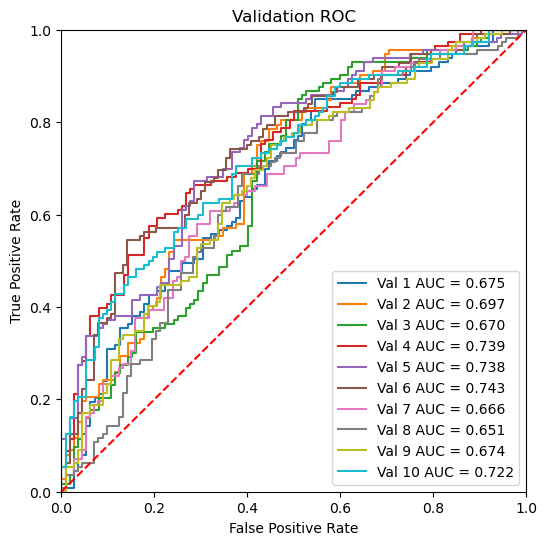

In [428]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

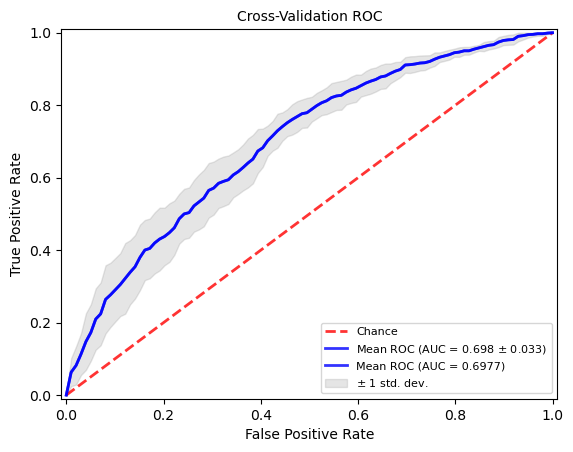

In [429]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [430]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [431]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [432]:
my_calculate_metrics_list_val

[{'SN': 0.5132743362831859,
  'SP': 0.6964285714285714,
  'ACC': 0.6044444444444445,
  'MCC': 0.21327156276845316,
  'Recall': 0.5132743362831859,
  'Precision': 0.6304347826086957,
  'F1-score': 0.5658536585365853,
  'Cutoff': 0.5},
 {'SN': 0.5357142857142857,
  'SP': 0.7589285714285714,
  'ACC': 0.6473214285714286,
  'MCC': 0.30226929284402326,
  'Recall': 0.5357142857142857,
  'Precision': 0.6896551724137931,
  'F1-score': 0.6030150753768844,
  'Cutoff': 0.5},
 {'SN': 0.34513274336283184,
  'SP': 0.8303571428571429,
  'ACC': 0.5866666666666667,
  'MCC': 0.2005986902594787,
  'Recall': 0.34513274336283184,
  'Precision': 0.6724137931034483,
  'F1-score': 0.45614035087719296,
  'Cutoff': 0.5},
 {'SN': 0.5132743362831859,
  'SP': 0.8214285714285714,
  'ACC': 0.6666666666666666,
  'MCC': 0.3516428162899104,
  'Recall': 0.5132743362831859,
  'Precision': 0.7435897435897436,
  'F1-score': 0.6073298429319371,
  'Cutoff': 0.5},
 {'SN': 0.8141592920353983,
  'SP': 0.5535714285714286,
  'ACC'

In [433]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.513274,0.696429,0.604444,0.213272,0.513274,0.630435,0.565854,0.5
1,0.535714,0.758929,0.647321,0.302269,0.535714,0.689655,0.603015,0.5
2,0.345133,0.830357,0.586667,0.200599,0.345133,0.672414,0.456140,0.5
3,0.513274,0.821429,0.666667,0.351643,0.513274,0.743590,0.607330,0.5
4,0.814159,0.553571,0.684444,0.381061,0.814159,0.647887,0.721569,0.5
5,0.714286,0.646018,0.680000,0.361103,0.714286,0.666667,0.689655,0.5
6,0.428571,0.761062,0.595556,0.201135,0.428571,0.640000,0.513369,0.5
7,0.473214,0.725664,0.600000,0.205582,0.473214,0.630952,0.540816,0.5
8,0.830357,0.362832,0.595556,0.218430,0.830357,0.563636,0.671480,0.5
9,0.633929,0.651786,0.642857,0.285760,0.633929,0.645455,0.639640,0.5


In [434]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.513274,0.696429,0.604444,0.213272,0.513274,0.630435,0.565854,0.5
1,0.535714,0.758929,0.647321,0.302269,0.535714,0.689655,0.603015,0.5
2,0.345133,0.830357,0.586667,0.200599,0.345133,0.672414,0.456140,0.5
3,0.513274,0.821429,0.666667,0.351643,0.513274,0.743590,0.607330,0.5
4,0.814159,0.553571,0.684444,0.381061,0.814159,0.647887,0.721569,0.5
5,0.714286,0.646018,0.680000,0.361103,0.714286,0.666667,0.689655,0.5
6,0.428571,0.761062,0.595556,0.201135,0.428571,0.640000,0.513369,0.5
7,0.473214,0.725664,0.600000,0.205582,0.473214,0.630952,0.540816,0.5
8,0.830357,0.362832,0.595556,0.218430,0.830357,0.563636,0.671480,0.5
9,0.633929,0.651786,0.642857,0.285760,0.633929,0.645455,0.639640,0.5


In [435]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [436]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [437]:
roc_auc_list_indep

[0.6911670918367346,
 0.6902901785714286,
 0.6912468112244897,
 0.6878188775510203,
 0.6887755102040817,
 0.6854272959183674,
 0.6943558673469389,
 0.6915656887755102,
 0.6673309948979592,
 0.6843909438775511]

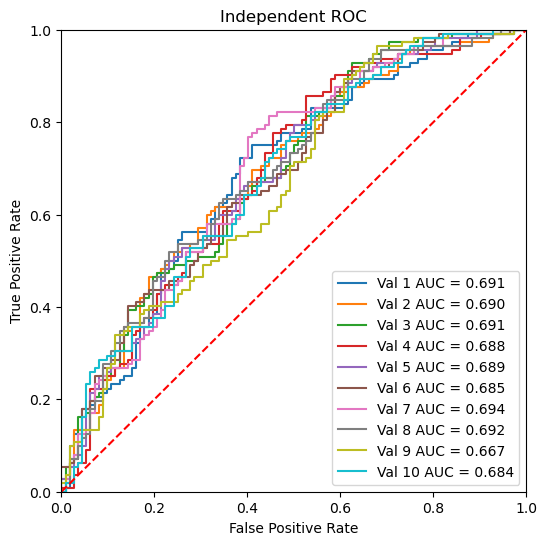

In [438]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

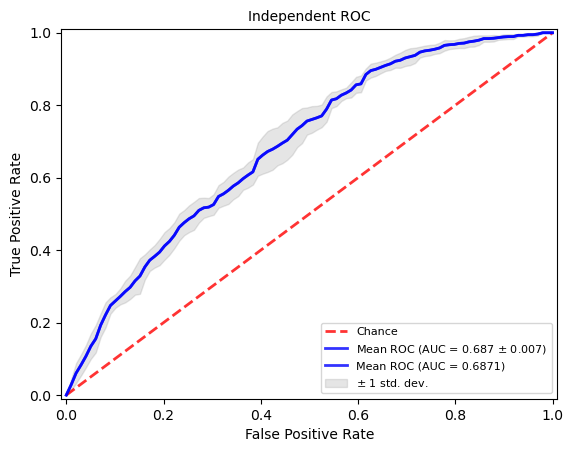

In [439]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [440]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [441]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [442]:
my_calculate_metrics_list_indep

[{'SN': 0.5982142857142857,
  'SP': 0.6696428571428571,
  'ACC': 0.6339285714285714,
  'MCC': 0.2685430777647873,
  'Recall': 0.5982142857142857,
  'Precision': 0.6442307692307693,
  'F1-score': 0.6203703703703703,
  'Cutoff': 0.5},
 {'SN': 0.5178571428571429,
  'SP': 0.75,
  'ACC': 0.6339285714285714,
  'MCC': 0.2753800572577618,
  'Recall': 0.5178571428571429,
  'Precision': 0.6744186046511628,
  'F1-score': 0.5858585858585859,
  'Cutoff': 0.5},
 {'SN': 0.39285714285714285,
  'SP': 0.8571428571428571,
  'ACC': 0.625,
  'MCC': 0.28226724349092913,
  'Recall': 0.39285714285714285,
  'Precision': 0.7333333333333333,
  'F1-score': 0.5116279069767442,
  'Cutoff': 0.5},
 {'SN': 0.39285714285714285,
  'SP': 0.8035714285714286,
  'ACC': 0.5982142857142857,
  'MCC': 0.21543793099105052,
  'Recall': 0.39285714285714285,
  'Precision': 0.6666666666666666,
  'F1-score': 0.4943820224719101,
  'Cutoff': 0.5},
 {'SN': 0.6875,
  'SP': 0.5267857142857143,
  'ACC': 0.6071428571428571,
  'MCC': 0.21710

In [443]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.598214,0.669643,0.633929,0.268543,0.598214,0.644231,0.620370,0.5
1,0.517857,0.750000,0.633929,0.275380,0.517857,0.674419,0.585859,0.5
2,0.392857,0.857143,0.625000,0.282267,0.392857,0.733333,0.511628,0.5
3,0.392857,0.803571,0.598214,0.215438,0.392857,0.666667,0.494382,0.5
4,0.687500,0.526786,0.607143,0.217108,0.687500,0.592308,0.636364,0.5
5,0.642857,0.598214,0.620536,0.241312,0.642857,0.615385,0.628821,0.5
6,0.446429,0.750000,0.598214,0.206157,0.446429,0.641026,0.526316,0.5
7,0.517857,0.750000,0.633929,0.275380,0.517857,0.674419,0.585859,0.5
8,0.803571,0.446429,0.625000,0.267652,0.803571,0.592105,0.681818,0.5
9,0.544643,0.696429,0.620536,0.243897,0.544643,0.642105,0.589372,0.5


In [444]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.598214,0.669643,0.633929,0.268543,0.598214,0.644231,0.620370,0.5
1,0.517857,0.750000,0.633929,0.275380,0.517857,0.674419,0.585859,0.5
2,0.392857,0.857143,0.625000,0.282267,0.392857,0.733333,0.511628,0.5
3,0.392857,0.803571,0.598214,0.215438,0.392857,0.666667,0.494382,0.5
4,0.687500,0.526786,0.607143,0.217108,0.687500,0.592308,0.636364,0.5
5,0.642857,0.598214,0.620536,0.241312,0.642857,0.615385,0.628821,0.5
6,0.446429,0.750000,0.598214,0.206157,0.446429,0.641026,0.526316,0.5
7,0.517857,0.750000,0.633929,0.275380,0.517857,0.674419,0.585859,0.5
8,0.803571,0.446429,0.625000,0.267652,0.803571,0.592105,0.681818,0.5
9,0.544643,0.696429,0.620536,0.243897,0.544643,0.642105,0.589372,0.5


In [445]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\unfreeze\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [446]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

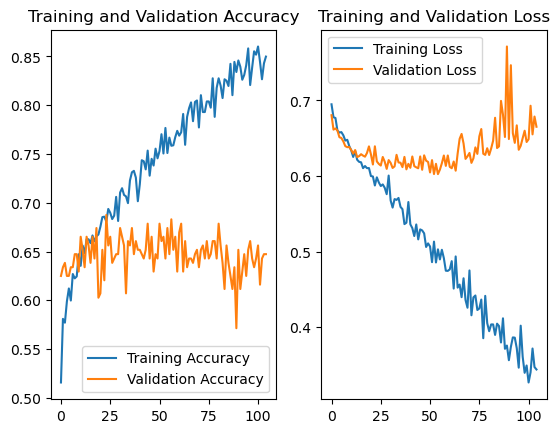

In [447]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()